This is the documentation for "M1M2: Deep-Learning-Based Real-Time Emotion Recognition from Neural Activity" paper by

Sumya Akter 1†, Rumman Ahmed Prodhan 1†, Tanmoy Sarkar Pias 2* , David Eisenberg 3*
and Jorge Fresneda Fernandez 1

1.   Martin Tuchman School of Management, New Jersey Institute of Technology, Newark, NJ 07102, USA 
2.   Department of Computer Science, Virginia Tech, Blacksburg, VA 24061, USA
3. Department of Information Systems, Ying Wu College of Computing, New Jersey Institute of Technology, Newark, NJ 07102, USA

\* Correspondence: tanmoysarkar@vt.edu (T.S.P.); de63@njit.edu (D.E.)

† These authors contributed equally to this work.

Published in MDPI Sensors: https://www.mdpi.com/1424-8220/22/21/8467

https://doi.org/10.3390/s22218467 









Table 11. Varying window size with respective time slice using FFT on M2+FFT+FE-3 for valence

**Pyeeg has been installed**

In [ ]:
pip install git+https://github.com/forrestbao/pyeeg.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/forrestbao/pyeeg.git to /tmp/pip-req-build-ytkn1wyh
  Running command git clone -q https://github.com/forrestbao/pyeeg.git /tmp/pip-req-build-ytkn1wyh
  Created wheel for pyeeg: filename=pyeeg-0.4.4-py2.py3-none-any.whl size=28131 sha256=7ba60ef26da723205a84e9d9922616887a0565c58665b55b64e4d391fd276c03
  Stored in directory: /tmp/pip-ephem-wheel-cache-ojsgx2hm/wheels/b0/23/e4/703c908bda656959957029fa145879aa79307b2545a2ef0271
Successfully built pyeeg


**Here is the code for mounting google drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pyeeg

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


**Imported the necessery library packages**

In [ ]:
import numpy as np
import pyeeg as pe
import pickle as pickle
import pandas as pd
import math

from sklearn import svm
from sklearn.preprocessing import normalize

import os
import time

**Location of dat file and location for where to save preprocessed npy files.
We've changed the location of where to save preprocessed npy files for each different window size.**

In [ ]:
path_to_dataset_2 = '/content/drive/Shareddrives/DEAP EEG/Dataset/physiological_recordings/data_preprocessed_python/' #Location of dat file of DEAP dataset
path_to_dataset = '/content/drive/Shareddrives/DEAP EEG/Preprocessed_data/window_size/8/' #where to save preprocessed npy files

**Intialize the channel array, band array, window_size, step_size and sample_rate and set the path of dataset of google drive.**

To experiment with different window size, we changed the value of window_size variable here.

In [ ]:
channel = [1,2,3,4,6,11,13,17,19,20,21,25,29,31] #14 Channels chosen to fit Emotiv Epoch+

band = [4,8,12,16,25,45] #5 bands

window_size = 8 #Averaging band power of 2 sec// 
#window_size = [128, 256, ..., 8064]

step_size = 16 #Each 0.125 sec update once

sample_rate = 128 #Sampling rate of 128 Hz

subjectList=[] #taking an empty array to store subject numbers here
for i in range(1,33):
  if i<10:
     subjectList.append(f"{i:02d}") #to add extra '0' infront of 1 to 9 single digits
  else:
    subjectList.append(f"{i:2d}")


**Declaring FFT function. Taking the preprocessed dat file and converting it to a preprocessed npy file after FFT**

In [ ]:
def FFT_Processing (sub, channel, band, window_size, step_size, sample_rate):
    '''
    arguments:  string subject
                list channel indice
                list band
                int window size for FFT
                int step size for FFT
                int sample rate for FFT
    return:     void
    '''
    meta = []
    with open(path_to_dataset_2+'s' + sub + '.dat', 'rb') as file:

        subject = pickle.load(file, encoding='latin1') #resolve the python 2 data problem by encoding : latin1

        for i in range (0,40):
            # loop over 0-39 trails
            data = subject["data"][i]
            labels = subject["labels"][i]
            start = 0;

            while start + window_size < data.shape[1]:
                meta_array = []
                meta_data = [] #meta vector for analysis
                for j in channel:
                    X = data[j][start : start + window_size] #Slice raw data over 2 sec, at interval of 0.125 sec
                    Y = pe.bin_power(X, band, sample_rate) #FFT over 2 sec of channel j, in seq of theta, alpha, low beta, high beta, gamma
                    meta_data = meta_data + list(Y[0])

                meta_array.append(np.array(meta_data))
                meta_array.append(labels)

                meta.append(np.array(meta_array))    
                start = start + step_size
                
        meta = np.array(meta)
        np.save(path_to_dataset+'s' + sub, meta, allow_pickle=True, fix_imports=True) #saving each of the 32 files as npy after preprocessing

**Calling the FFT functions for each subjects**

In [ ]:
for subjects in subjectList:
    FFT_Processing (subjects, channel, band, window_size, step_size, sample_rate)

In [ ]:
import numpy as np
# save np.load
np_load_old = np.load

# modify the default parameters of np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

##Dividing the Data into Training and Testing


#spliting and appending each npy into training, testing (75/25)
Dividing the 32 preprocessed npy file into data training, label training, data testing and label testing. Every npy file has 19520 rows and 4 columns which are valence, arousal, dominace and likings. Every npy file was divided by 4.

For each npy file

*   Training : 19520-4880=14640 (75%)
*   Testing : 19520/4=4880 (25%)

For training and testing
* The data training and label training both has 14640*32=468480 rows (75%)
* The data testing and label testing both has 4880*32=156160 rows (25%)









In [ ]:
data_training = []
label_training = []
data_testing = []
label_testing = []

for subjects in subjectList:

    with open(path_to_dataset + 's' + subjects + '.npy', 'rb') as file: 
        sub = np.load(file) # loading npy file
        for i in range (0,sub.shape[0]): # running loop over 19520 rows
            if i % 4 == 0: # 19520/4=4880 (25%)
                data_testing.append(sub[i][0])
                label_testing.append(sub[i][1])
            else: # 19520-4880=14640 (75%)
                data_training.append(sub[i][0])
                label_training.append(sub[i][1])

In [ ]:
# restore np.load for future normal usage
np.load = np_load_old

**Saving the data training, label training, data testing and label testing into google drive**


In [ ]:
np.save(path_to_dataset + 'data_training', np.array(data_training), allow_pickle=True, fix_imports=True)
np.save(path_to_dataset + 'label_training', np.array(label_training), allow_pickle=True, fix_imports=True)
print("training dataset:", np.array(data_training).shape, np.array(label_training).shape)

np.save(path_to_dataset + 'data_testing', np.array(data_testing), allow_pickle=True, fix_imports=True)
np.save(path_to_dataset + 'label_testing', np.array(label_testing), allow_pickle=True, fix_imports=True)
print("testing dataset:", np.array(data_testing).shape, np.array(label_testing).shape)

training dataset: (483840, 70) (483840, 4)
testing dataset: (161280, 70) (161280, 4)


**Here all the training file have been loaded .The data have been put in variable X and label values have been put in Y.Then the X has been Normalized and then valence label values have been loaded in Z. And then all the '9' values are converted into '8.99' of valence label.**

In [ ]:
with open(path_to_dataset + 'data_training.npy', 'rb') as fileTrain:
    X  = np.load(fileTrain)
    
with open(path_to_dataset + 'label_training.npy', 'rb') as fileTrainL:
    Y  = np.load(fileTrainL)
    
X = normalize(X)
Z = np.ravel(Y[:, [0]])

Valence_Train = np.ravel(Y[:, [0]])
Arousal_Train = np.ravel(Y[:, [1]])
Domain_Train = np.ravel(Y[:, [2]])
Like_Train = np.ravel(Y[:, [3]])

for i in range(len(Z)):
  if Z[i] == 9:
    Z[i] = 8.99

In [ ]:
Arousal_Train = Arousal_Train.reshape((483840, 1))
Domain_Train = Domain_Train.reshape((483840, 1))
Like_Train = Like_Train.reshape((483840, 1))

train = np.hstack([X, Arousal_Train, Domain_Train, Like_Train])
train.shape

(483840, 73)

In [ ]:
X_old = X
X = train

**All the training label values are divided into two segments. One segment contains values from 1 - 4.9 and another contains rest of the range's values. This approch is maintained for valence, arousal, dominance, likings binary classifications but not for other class classification.**


In [ ]:
count_0 = 0
count_1 = 0
for i in range(len(Z)):
  if Z[i] >= 1 and Z[i]<=4.99:
    Z [i] = 0
    count_0 = count_0 + 1
  else:
    Z [i] = 1
    count_1 = count_1 + 1
print(count_0,count_1)

210168 273672


**Necessery libraries are imported**


In [ ]:
import pandas as pd
import keras.backend as K
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.layers.convolutional import Conv1D
from tensorflow.keras.utils import to_categorical 
from keras.layers import Flatten
from keras.layers import Dense
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras import backend as K
from keras.models import Model
import timeit
from keras.layers.core import Flatten, Dense, Dropout
from keras.layers.convolutional import Convolution1D, MaxPooling1D, ZeroPadding1D
import warnings
warnings.filterwarnings('ignore')

**Here all the training label values are categorised. For binary classification and it is catagorised into two catagory. value range 1 - 4.99 have been assigned in catagory '0' and rest of the value are assigned in catagory '1'.** 

1.  1-4.99 ----> catagory(0)
2.  5-8.99 ----> catagory(1)

In [ ]:
y_train = to_categorical(Z)
y_train[:10]

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

**Values of X are put in x_train as numpy array format**

In [ ]:
x_train = np.array(X[:])

**Here all the testing file have been loaded .The data have been put in variable M and label values have been put in N.Then the M has been Normalized and then valence label values have been loaded in L. And then all the '9' values are converted into '8.99' of valence label.**

In [ ]:
with open(path_to_dataset + 'data_testing.npy', 'rb') as fileTrain:
    M  = np.load(fileTrain)
    
with open(path_to_dataset + 'label_testing.npy', 'rb') as fileTrainL:
    N  = np.load(fileTrainL)

M = normalize(M)
L = np.ravel(N[:, [0]])


Valence_Test = np.ravel(N[:, [0]])
Arousal_Test = np.ravel(N[:, [1]])
Domain_Test = np.ravel(N[:, [2]])
Like_Test = np.ravel(N[:, [3]])

for i in range(len(L)):
  if L[i] == 9:
    L[i] = 8.99

**All the testing labels values are divided into two segments. One segment contains values from 1 - 4.9 and another contains rest of the range's values. This approch is maintained for valence, arousal, dominance, likings binary classifications but not for other class classification.**

In [ ]:
count_0 = 0
count_1 = 0
for i in range(len(L)):
  if L[i] >= 1 and L[i]<=4.99:
    L [i] = 0
    count_0 = count_0 + 1
  else:
    L [i] = 1
    count_1 = count_1 + 1
print(count_0,count_1)

70056 91224


In [ ]:
M.shape

(161280, 70)

In [ ]:
Arousal_Test = Arousal_Test.reshape((161280, 1))
Domain_Test = Domain_Test.reshape((161280, 1))
Like_Test = Like_Test.reshape((161280, 1))

test = np.hstack([M, Arousal_Test, Domain_Test, Like_Test])
test.shape

(161280, 73)

**Vules of M are assigned in x_test in numpy array format**

In [ ]:
x_test = np.array(test[:])
x_test

array([[0.  , 0.  , 0.  , ..., 7.6 , 6.9 , 7.83],
       [0.  , 0.  , 0.  , ..., 7.6 , 6.9 , 7.83],
       [0.  , 0.  , 0.  , ..., 7.6 , 6.9 , 7.83],
       ...,
       [0.  , 0.  , 0.  , ..., 4.03, 9.  , 1.88],
       [0.  , 0.  , 0.  , ..., 4.03, 9.  , 1.88],
       [0.  , 0.  , 0.  , ..., 4.03, 9.  , 1.88]])

**Here all the tessting labels values are categorised. For binary classification and it is catagorised into two catagory. value range 1 - 4.99 have been assigned in catagory '0' and rest of the value are assigned in catagory '1'.**

* 1-4.99 ----> catagory(0)
* 5-8.99 ----> catagory(1)

In [ ]:
from tensorflow.keras.utils import to_categorical 
y_test = to_categorical(L)

**Fit the train and test data with StandarScaler**

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)
#x_test = scaler.transform(x_test)

In [ ]:
x_test = scaler.transform(x_test)

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.fit_transform(x_test)

**Two dimensional data are converted into three dimension by adding one constant dimension’s value '1'. This is for CNN, LSTM and Bi-LSTM only**

In [ ]:
x_train = x_train.reshape(x_train.shape[0],x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1], 1)

In [ ]:
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(483840, 73, 1) (161280, 73, 1) (483840, 2) (161280, 2)


In [ ]:
print(x_train.shape,  y_train.shape)

(483840, 73, 1) (483840, 2)


**Here define the batch_size, number of class used in model architecture ,how many epoch will be run with the model and also define the input_shape. This is for CNN, LSTM and Bi-LSTM only**

In [ ]:
batch_size = 256
num_classes = 2
epochs = 100

input_shape=(x_train.shape[1], 1)

**import another library packages**

In [ ]:
from keras.layers import Convolution1D, ZeroPadding1D, MaxPooling1D, BatchNormalization, Activation, Dropout, Flatten, Dense
from keras.regularizers import l2
from keras.layers import Input
from keras.layers.merge import concatenate
from keras.layers import Input
from keras.layers.merge import concatenate
from keras.utils.vis_utils import plot_model

# Deep Learning Algorithms

##CNN Model with Residual Connection

**M2 CNN Model**

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 73, 1)]      0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 73, 16)       112         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 73, 16)      64          ['conv1d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 max_pooling1d (MaxPooling1D)   (None, 36, 16)       0           ['batch_normalization[0][0]']

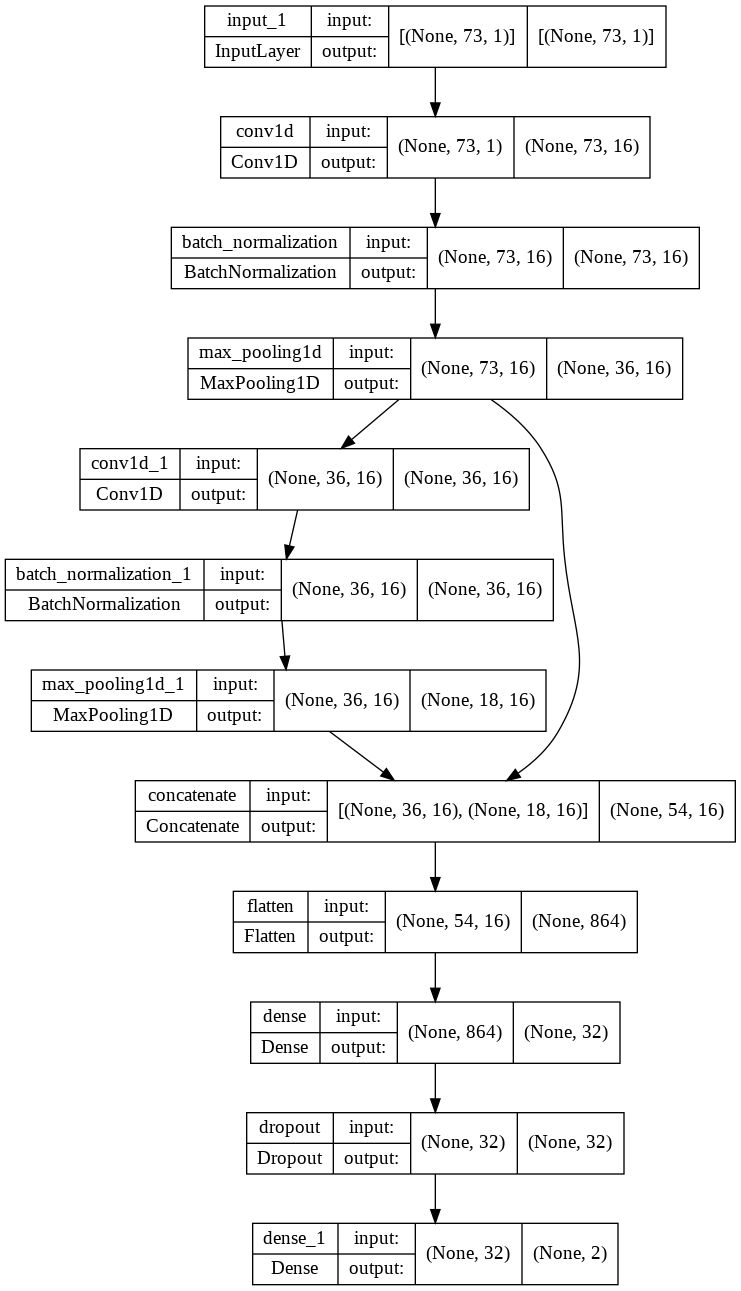

In [ ]:
from keras.layers import Input
from keras.layers.merge import concatenate
from keras.utils.vis_utils import plot_model


intput_shape=(x_train.shape[1], 1) #x_train.shape[1]

input_layer = Input(intput_shape)

conv1 = Conv1D(16, kernel_size=6,padding = 'same',activation='relu') (input_layer)
bn1 = BatchNormalization() (conv1)
pool1 = MaxPooling1D(pool_size=(2)) (bn1)

conv2 = Conv1D(16,kernel_size=6,padding = 'same', activation='relu') (pool1)
bn2 = BatchNormalization() (conv2) 
pool2 = MaxPooling1D(pool_size=(2)) (bn2)

connect1 = concatenate([pool1, pool2], axis=1)

flat = Flatten() (connect1)


dense3 = Dense(32, activation='relu') (flat)
drop3 = Dropout(0.2) (dense3)

output_layer = Dense(2, activation='softmax') (drop3) #num_classes

model = Model(input_layer, output_layer)
model.summary()
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

**Compiling the model**

In [ ]:
model.compile(loss=keras.losses.categorical_crossentropy, 
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
# check points and early stopping
from keras.callbacks import ModelCheckpoint,EarlyStopping

model_name = ""
filepath="/content/drive/Shareddrives/DEAP EEG/Models Saved/Valence/window_size_M2_FX_FE_3/8/"  + model_name + "weights-improvement-{epoch:02d}-{accuracy:.4f}.hdf5"
print(filepath)
checkpoint = ModelCheckpoint(filepath, monitor='accuracy', verbose=1, save_best_only=True, mode='max')
es = EarlyStopping(monitor='accuracy', mode='max', verbose=1, patience=10)
callbacks_list = [es, checkpoint]

/content/drive/Shareddrives/DEAP EEG/Models Saved/Valence/window_size_M2_FX_FE_3/8/weights-improvement-{epoch:02d}-{accuracy:.4f}.hdf5


**Window size 8 on M2+FFT+FE-3 for Valence**

In [ ]:
H = model.fit(x_train, y_train,
          batch_size=100,
          epochs=100,
          verbose=1,
          validation_data=(x_test, y_test),
          callbacks= callbacks_list)

Epoch 1/100
4834/4839 [============================>.] - ETA: 0s - loss: 0.1731 - accuracy: 0.9163
Epoch 1: accuracy improved from -inf to 0.91632, saving model to /content/drive/Shareddrives/DEAP EEG/Models Saved/Valence/window_size_M2_FX_FE_3/8/weights-improvement-01-0.9163.hdf5
4839/4839 [==============================] - 42s 8ms/step - loss: 0.1731 - accuracy: 0.9163 - val_loss: 0.1407 - val_accuracy: 0.9365
Epoch 2/100
4836/4839 [============================>.] - ETA: 0s - loss: 0.1732 - accuracy: 0.9162
Epoch 2: accuracy did not improve from 0.91632
4839/4839 [==============================] - 37s 8ms/step - loss: 0.1732 - accuracy: 0.9162 - val_loss: 0.1442 - val_accuracy: 0.9349
Epoch 3/100
4834/4839 [============================>.] - ETA: 0s - loss: 0.1725 - accuracy: 0.9169
Epoch 3: accuracy improved from 0.91632 to 0.91687, saving model to /content/drive/Shareddrives/DEAP EEG/Models Saved/Valence/window_size_M2_FX_FE_3/8/weights-improvement-03-0.9169.hdf5
4839/4839 [========

In [ ]:
score = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

5040/5040 [==============================] - 19s 4ms/step - loss: 0.1222 - accuracy: 0.9447
Test loss: 0.12224286049604416
Test accuracy: 0.944686233997345


In [ ]:
with open('/content/drive/Shareddrives/DEAP EEG/Models Saved/Valence/window_size_M2_FX_FE_3/8/history', 'wb') as file_pi:
        pickle.dump(H.history, file_pi)

**Window size 4 on M2+FFT+FE-3 for Valence**

In [ ]:
H = model.fit(x_train, y_train,
          batch_size=100,
          epochs=100,
          verbose=1,
          validation_data=(x_test, y_test),
          callbacks= callbacks_list)

Epoch 1/100
4839/4839 [==============================] - ETA: 0s - loss: 0.4077 - accuracy: 0.8100
Epoch 1: accuracy improved from -inf to 0.81005, saving model to /content/drive/Shareddrives/DEAP EEG/Models Saved/Valence/window_size_M2_FX_FE_3/4/weights-improvement-01-0.8100.hdf5
4839/4839 [==============================] - 41s 8ms/step - loss: 0.4077 - accuracy: 0.8100 - val_loss: 0.3629 - val_accuracy: 0.8257
Epoch 2/100
4833/4839 [============================>.] - ETA: 0s - loss: 0.3624 - accuracy: 0.8265
Epoch 2: accuracy improved from 0.81005 to 0.82651, saving model to /content/drive/Shareddrives/DEAP EEG/Models Saved/Valence/window_size_M2_FX_FE_3/4/weights-improvement-02-0.8265.hdf5
4839/4839 [==============================] - 41s 8ms/step - loss: 0.3623 - accuracy: 0.8265 - val_loss: 0.3341 - val_accuracy: 0.8380
Epoch 3/100
4832/4839 [============================>.] - ETA: 0s - loss: 0.3401 - accuracy: 0.8344
Epoch 3: accuracy improved from 0.82651 to 0.83442, saving model t

In [ ]:
score = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

5040/5040 [==============================] - 19s 4ms/step - loss: 0.1446 - accuracy: 0.9353
Test loss: 0.14456458389759064
Test accuracy: 0.9353112578392029


In [ ]:
with open('/content/drive/Shareddrives/DEAP EEG/Models Saved/Valence/window_size_M2_FX_FE_3/4/history', 'wb') as file_pi:
        pickle.dump(H.history, file_pi)

**Window size 16 on M2+FFT+FE-3 for Valence**

In [ ]:
H = model.fit(x_train, y_train,
          batch_size=100,
          epochs=100,
          verbose=1,
          validation_data=(x_test, y_test),
          callbacks= callbacks_list)

Epoch 1/100
4829/4829 [==============================] - ETA: 0s - loss: 0.3903 - accuracy: 0.8179
Epoch 1: accuracy improved from -inf to 0.81787, saving model to /content/drive/Shareddrives/DEAP EEG/Models Saved/Valence/window_size_M2_FX_FE_3/16/weights-improvement-01-0.8179.hdf5
4829/4829 [==============================] - 32s 6ms/step - loss: 0.3903 - accuracy: 0.8179 - val_loss: 0.3257 - val_accuracy: 0.8498
Epoch 2/100
4825/4829 [============================>.] - ETA: 0s - loss: 0.3188 - accuracy: 0.8528
Epoch 2: accuracy improved from 0.81787 to 0.85277, saving model to /content/drive/Shareddrives/DEAP EEG/Models Saved/Valence/window_size_M2_FX_FE_3/16/weights-improvement-02-0.8528.hdf5
4829/4829 [==============================] - 33s 7ms/step - loss: 0.3188 - accuracy: 0.8528 - val_loss: 0.2782 - val_accuracy: 0.8733
Epoch 3/100
4826/4829 [============================>.] - ETA: 0s - loss: 0.2891 - accuracy: 0.8665
Epoch 3: accuracy improved from 0.85277 to 0.86645, saving model

In [ ]:
score = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

5030/5030 [==============================] - 14s 3ms/step - loss: 0.0974 - accuracy: 0.9604
Test loss: 0.09739240258932114
Test accuracy: 0.9604436159133911


In [ ]:
with open('/content/drive/Shareddrives/DEAP EEG/Models Saved/Valence/window_size_M2_FX_FE_3/16/history', 'wb') as file_pi:
        pickle.dump(H.history, file_pi)

**Window size 32 on M2+FFT+FE-3 for Valence**

In [ ]:
H = model.fit(x_train, y_train,
          batch_size=100,
          epochs=100,
          verbose=1,
          validation_data=(x_test, y_test),
          callbacks= callbacks_list)

Epoch 1/100
4820/4820 [==============================] - ETA: 0s - loss: 0.3768 - accuracy: 0.8253
Epoch 1: accuracy improved from -inf to 0.82529, saving model to /content/drive/Shareddrives/DEAP EEG/Models Saved/Valence/window_size_M2_FX_FE_3/32/weights-improvement-01-0.8253.hdf5
4820/4820 [==============================] - 29s 6ms/step - loss: 0.3768 - accuracy: 0.8253 - val_loss: 0.3025 - val_accuracy: 0.8606
Epoch 2/100
4817/4820 [============================>.] - ETA: 0s - loss: 0.2945 - accuracy: 0.8607
Epoch 2: accuracy improved from 0.82529 to 0.86069, saving model to /content/drive/Shareddrives/DEAP EEG/Models Saved/Valence/window_size_M2_FX_FE_3/32/weights-improvement-02-0.8607.hdf5
4820/4820 [==============================] - 27s 6ms/step - loss: 0.2945 - accuracy: 0.8607 - val_loss: 0.2484 - val_accuracy: 0.8806
Epoch 3/100
4811/4820 [============================>.] - ETA: 0s - loss: 0.2562 - accuracy: 0.8764
Epoch 3: accuracy improved from 0.86069 to 0.87644, saving model

In [ ]:
score = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

5020/5020 [==============================] - 14s 3ms/step - loss: 0.0673 - accuracy: 0.9701
Test loss: 0.06734304875135422
Test accuracy: 0.9700697064399719


In [ ]:
with open('/content/drive/Shareddrives/DEAP EEG/Models Saved/Valence/window_size_M2_FX_FE_3/32/history', 'wb') as file_pi:
        pickle.dump(H.history, file_pi)

**Window size 64 on M2+FFT+FE-3 for Valence**

In [ ]:
H = model.fit(x_train, y_train,
          batch_size=100,
          epochs=100,
          verbose=1,
          validation_data=(x_test, y_test),
          callbacks= callbacks_list)

Epoch 1/100
4798/4800 [============================>.] - ETA: 0s - loss: 0.3555 - accuracy: 0.8336
Epoch 1: accuracy improved from -inf to 0.83358, saving model to /content/drive/Shareddrives/DEAP EEG/Models Saved/Valence/window_size_M2_FX_FE_3/64/weights-improvement-01-0.8336.hdf5
4800/4800 [==============================] - 25s 5ms/step - loss: 0.3555 - accuracy: 0.8336 - val_loss: 0.2745 - val_accuracy: 0.8725
Epoch 2/100
4791/4800 [============================>.] - ETA: 0s - loss: 0.2618 - accuracy: 0.8751
Epoch 2: accuracy improved from 0.83358 to 0.87510, saving model to /content/drive/Shareddrives/DEAP EEG/Models Saved/Valence/window_size_M2_FX_FE_3/64/weights-improvement-02-0.8751.hdf5
4800/4800 [==============================] - 25s 5ms/step - loss: 0.2618 - accuracy: 0.8751 - val_loss: 0.2101 - val_accuracy: 0.9030
Epoch 3/100
4795/4800 [============================>.] - ETA: 0s - loss: 0.2160 - accuracy: 0.8970
Epoch 3: accuracy improved from 0.87510 to 0.89696, saving model

In [ ]:
score = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

5000/5000 [==============================] - 13s 3ms/step - loss: 0.0482 - accuracy: 0.9793
Test loss: 0.04817533865571022
Test accuracy: 0.9792624711990356


In [ ]:
with open('/content/drive/Shareddrives/DEAP EEG/Models Saved/Valence/window_size_M2_FX_FE_3/64/history', 'wb') as file_pi:
        pickle.dump(H.history, file_pi)

**Window size 128 on M2+FFT+FE-3 for Valence**

In [ ]:
H = model.fit(x_train, y_train,
          batch_size=100,
          epochs=100,
          verbose=1,
          validation_data=(x_test, y_test),
          callbacks= callbacks_list)

Epoch 1/100
4762/4762 [==============================] - ETA: 0s - loss: 0.3324 - accuracy: 0.8444
Epoch 1: accuracy improved from -inf to 0.84439, saving model to /content/drive/Shareddrives/DEAP EEG/Models Saved/Valence/window_size_M2_FX_FE_3/128/weights-improvement-01-0.8444.hdf5
4762/4762 [==============================] - 38s 6ms/step - loss: 0.3324 - accuracy: 0.8444 - val_loss: 0.2330 - val_accuracy: 0.8905
Epoch 2/100
4757/4762 [============================>.] - ETA: 0s - loss: 0.2249 - accuracy: 0.8903
Epoch 2: accuracy improved from 0.84439 to 0.89037, saving model to /content/drive/Shareddrives/DEAP EEG/Models Saved/Valence/window_size_M2_FX_FE_3/128/weights-improvement-02-0.8904.hdf5
4762/4762 [==============================] - 26s 5ms/step - loss: 0.2249 - accuracy: 0.8904 - val_loss: 0.1634 - val_accuracy: 0.9219
Epoch 3/100
4757/4762 [============================>.] - ETA: 0s - loss: 0.1834 - accuracy: 0.9089
Epoch 3: accuracy improved from 0.89037 to 0.90892, saving mod

In [ ]:
score = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

4960/4960 [==============================] - 14s 3ms/step - loss: 0.0318 - accuracy: 0.9872
Test loss: 0.031797148287296295
Test accuracy: 0.9872164726257324


In [ ]:
with open('/content/drive/Shareddrives/DEAP EEG/Models Saved/Valence/window_size_M2_FX_FE_3/128/history', 'wb') as file_pi:
        pickle.dump(H.history, file_pi)

**Window size 256 on M2+FFT+FE-3 for Valence**

In [ ]:
H = model.fit(x_train, y_train,
          batch_size=100,
          epochs=100,
          verbose=1,
          callbacks= callbacks_list)

Epoch 1/100
4678/4685 [============================>.] - ETA: 0s - loss: 0.3000 - accuracy: 0.8624
Epoch 1: accuracy improved from -inf to 0.86245, saving model to /content/drive/Shareddrives/DEAP EEG/Models Saved/Valence/MDPI_Conv_Layer/c3,4,d1,2/weights-improvement-01-0.8625.hdf5
4685/4685 [==============================] - 22s 5ms/step - loss: 0.2999 - accuracy: 0.8625
Epoch 2/100
4679/4685 [============================>.] - ETA: 0s - loss: 0.1876 - accuracy: 0.9117
Epoch 2: accuracy improved from 0.86245 to 0.91169, saving model to /content/drive/Shareddrives/DEAP EEG/Models Saved/Valence/MDPI_Conv_Layer/c3,4,d1,2/weights-improvement-02-0.9117.hdf5
4685/4685 [==============================] - 22s 5ms/step - loss: 0.1875 - accuracy: 0.9117
Epoch 3/100
4681/4685 [============================>.] - ETA: 0s - loss: 0.1512 - accuracy: 0.9275
Epoch 3: accuracy improved from 0.91169 to 0.92754, saving model to /content/drive/Shareddrives/DEAP EEG/Models Saved/Valence/MDPI_Conv_Layer/c3,4,d

**Evaluating the CNN model testing accuracy**

In [ ]:
score = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

4880/4880 [==============================] - 11s 2ms/step - loss: 0.0206 - accuracy: 0.9923
Test loss: 0.02064960077404976
Test accuracy: 0.9922963380813599


**Window size 512 on M2+FFT+FE-3 for Valence**

In [ ]:
H = model.fit(x_train, y_train,
          batch_size=100,
          epochs=100,
          verbose=1,
          validation_data=(x_test, y_test),
          callbacks= callbacks_list)

Epoch 1/100
4532/4532 [==============================] - ETA: 0s - loss: 0.2609 - accuracy: 0.8812
Epoch 1: accuracy improved from -inf to 0.88117, saving model to /content/drive/Shareddrives/DEAP EEG/Models Saved/Valence/window_size_M2_FX_FE_3/512/weights-improvement-01-0.8812.hdf5
4532/4532 [==============================] - 42s 6ms/step - loss: 0.2609 - accuracy: 0.8812 - val_loss: 0.1460 - val_accuracy: 0.9345
Epoch 2/100
4530/4532 [============================>.] - ETA: 0s - loss: 0.1451 - accuracy: 0.9316
Epoch 2: accuracy improved from 0.88117 to 0.93159, saving model to /content/drive/Shareddrives/DEAP EEG/Models Saved/Valence/window_size_M2_FX_FE_3/512/weights-improvement-02-0.9316.hdf5
4532/4532 [==============================] - 34s 8ms/step - loss: 0.1451 - accuracy: 0.9316 - val_loss: 0.0932 - val_accuracy: 0.9591
Epoch 3/100
4531/4532 [============================>.] - ETA: 0s - loss: 0.1140 - accuracy: 0.9452
Epoch 3: accuracy improved from 0.93159 to 0.94521, saving mod

In [ ]:
score = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

4720/4720 [==============================] - 13s 3ms/step - loss: 0.0079 - accuracy: 0.9979
Test loss: 0.007865656167268753
Test accuracy: 0.997901201248169


In [ ]:
with open('/content/drive/Shareddrives/DEAP EEG/Models Saved/Valence/window_size_M2_FX_FE_3/512/history', 'wb') as file_pi:
        pickle.dump(H.history, file_pi)

**Window size 1024 on M2+FFT+FE-3 for Valence**

In [ ]:
H = model.fit(x_train, y_train,
          batch_size=100,
          epochs=100,
          verbose=1,
          validation_data=(x_test, y_test),
          callbacks= callbacks_list)

Epoch 1/100
4219/4224 [============================>.] - ETA: 0s - loss: 0.2282 - accuracy: 0.8986
Epoch 1: accuracy improved from -inf to 0.89870, saving model to /content/drive/Shareddrives/DEAP EEG/Models Saved/Valence/window_size_M2_FX_FE_3/1024/weights-improvement-01-0.8987.hdf5
4224/4224 [==============================] - 41s 6ms/step - loss: 0.2281 - accuracy: 0.8987 - val_loss: 0.0938 - val_accuracy: 0.9625
Epoch 2/100
4217/4224 [============================>.] - ETA: 0s - loss: 0.1074 - accuracy: 0.9532
Epoch 2: accuracy improved from 0.89870 to 0.95318, saving model to /content/drive/Shareddrives/DEAP EEG/Models Saved/Valence/window_size_M2_FX_FE_3/1024/weights-improvement-02-0.9532.hdf5
4224/4224 [==============================] - 20s 5ms/step - loss: 0.1074 - accuracy: 0.9532 - val_loss: 0.0575 - val_accuracy: 0.9776
Epoch 3/100
4218/4224 [============================>.] - ETA: 0s - loss: 0.0822 - accuracy: 0.9642
Epoch 3: accuracy improved from 0.95318 to 0.96418, saving m

In [ ]:
score = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

4400/4400 [==============================] - 12s 3ms/step - loss: 0.0044 - accuracy: 0.9988
Test loss: 0.004418461117893457
Test accuracy: 0.9988139271736145


In [ ]:
with open('/content/drive/Shareddrives/DEAP EEG/Models Saved/Valence/window_size_M2_FX_FE_3/1024/history', 'wb') as file_pi:
        pickle.dump(H.history, file_pi)